# Max infection peak vs $\beta$ for different system size

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

plt.style.use("../config/custom_plots.mplstyle")

```yaml
nAgents: 10000
nSteps: 100
nSaveSteps: 1
nRuns: 5
networkP: 0.8
networkM: 10
additionalLinksFraction: 0.01
virtualLayer: true
epidemicLayer: true
comorbidities: false
qVoterParameters:
  p: 0.2
  q: 6
epidemicLayerParameters:
  beta: 0.1
  zeta: 0.0
  alpha: 0.0
  gamma: 0.5
  mu: 0.9
  kappa: 0.1
maxInfectedTimeMean: 10
maxInfectedTimeStd: 5
positiveOpinionFraction: 0.9
proPisFraction: 0.0
pisVaccinationCorrelation: 0.0
infectedFraction: 0.1
fractionIllnessA: 0.0
fractionIllnessB: 0.0
outputFolder: simulations/max_infection_peak_vs_beta
firstParameterRange:
  start: 0.0
  end: 1.0
  count: 21
  vals: null
  type: beta
secondParameterRange:
  start: 0
  end: 0
  count: 0
  vals: [1000, 10000, 30000]
  type: N
thirdParameterRange: null
#  start: 0
#  end: 0
#  count: 0
#  vals: [0.01, 0.05, 0.1, 0.3, 0.5]
#  type: p
linksRemoval: false
nQVoterPerStep: 1
vaccinationFraction: 0.0
neglectNeighboursPiS: false
```

In [43]:
def load_df(prefix, beta, folder, p, nagents, fracPos=0.9, q=6, qvotersteps=1, nsteps=100, nruns=5):
    dfs = []
    for n in range(nruns):
        path = f"../simulations/{folder}/{prefix}_NAGENTS={nagents}_NSTEPS={nsteps}_NETWORKP=0.8_FRAC_LINKS=0.01_FRAC_POS_OPINION={fracPos}_FRAC_INFECTED=0.1_QVOTER=p={p}_q={q}_PIS=0.0_EPIDEMIC=beta={beta}_zeta=0.00_alpha=0.00_gamma=0.50_mu=0.90_kappa=0.10_QVOTERSTEPS={qvotersteps}_NRUN={n}.tsv"
        
        df = pd.read_csv(path, sep="\t")
        dfs.append(df)
    dfs1 = pd.DataFrame(np.array([x.to_numpy() for x in dfs]).mean(axis=0),
                        index=df.index, 
                        columns=df.columns)
    return dfs1


# betas = ['{:.2f}'.format(x / 100) for x in list(range(101))][::4]
betas_float = [0.0, 0.05, 0.10,0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55,
               0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
betas = ['{:.2f}'.format(b) for b in betas_float]

# ps = ['0.01', '0.02', '0.10', '0.30', '0.50']
ps = ['0.05', '0.10', '0.30', '0.50']


sizes = [1000, 10000, 30000]

print('ps: ', ps)
print('Betas: ', betas, len(betas))

ps:  ['0.05', '0.10', '0.30', '0.50']
Betas:  ['0.00', '0.05', '0.10', '0.15', '0.20', '0.25', '0.30', '0.35', '0.40', '0.45', '0.50', '0.55', '0.60', '0.65', '0.70', '0.75', '0.80', '0.85', '0.90', '0.95', '1.00'] 21


In [46]:
def load_dfs(p, betas=betas, sizes=sizes, path='max_infection_peak_vs_beta', prefix='off'):
    """
    { N: list of dataframes, one per `beta` value }
    
    e.g.

    {size: [pd.DataFrame(beta=0.00), pd.DataFrame(beta=0.01), ...]}
    """
    xs = {}
    for N in tqdm(sizes):
        xs_per_N = []
        for beta in betas:
            df1 = load_df(prefix, beta, path, p, N)
            xs_per_N.append(df1)
        xs[N] = xs_per_N
    return xs


def load_all_dfs(ps):
    """
    { qvoterstep: {beta: list of dataframes}, ... }
    """
    df_per_p = {}
    for p in ps:
        df_per_p[p] = load_dfs(p)
    return df_per_p 

In [47]:
%%time


dfs_ps = load_all_dfs(ps)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 8.29 s, sys: 71.4 ms, total: 8.36 s
Wall time: 8.31 s


In [145]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


colors = ['red', 'green', 'blue', 'violet']
colors = ['xkcd:' + c for c in colors]
markers = ['o', 'v', '^']

def max_infection_rate(df):
    return df['infectedRate'].max()
    
def last_opinion(df):
    return df['meanOpinion'].to_numpy()[-1]

def last_recovered_rate(df):
    return df['recoveredRate'].to_numpy()[-1]

def time_max_infection(df):
    return df[df['infectedRate'] == df['infectedRate'].max()].step.to_numpy()[0]


def plot_max_infection_peak_vs_beta_per_beta(dfs, color, betas_float=betas_float, markers=markers, 
                                             fun=max_infection_rate):
    i = 0
    markers_legend = []
    for size, df in dfs.items():
        peaks = [fun(x) for x in df]
        plt.plot(betas_float, peaks, 'o--', label=f'N={size}', linewidth=1, color=color, 
                 marker=markers[i], mfc='none')
        
        l = Line2D([0], [0], marker=markers[i], color='black', label=f'N={size}',
                    markersize=12, mfc='none', linestyle='')
        markers_legend.append(l)
        i += 1
    
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$I_{max}$') # max infection rate
    return markers_legend
    
def plot_max_infection_peak_vs_beta_per_p(dfs_ps, fun=max_infection_rate):
    i = 0
    
    patches = []
    markers_legend = None
    for p, dfs in dfs_ps.items():
        markers_legend = plot_max_infection_peak_vs_beta_per_beta(dfs, colors[i], fun=fun)
        
        patch = Patch(facecolor=colors[i], label=f'p={p}')
        patches.append(patch)
        i += 1
        
    legend_elements = [*patches, *markers_legend]
    plt.legend(handles=legend_elements, ncol=2)

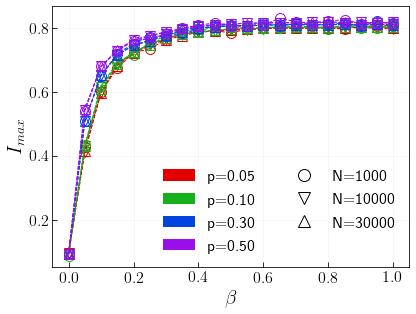

In [146]:
plot_max_infection_peak_vs_beta_per_p(dfs_ps, fun=max_infection_rate)
# plt.xlim(-0.01, 0.52)